In [5]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random

import wandb

import dro_sweeps.classification_data_generation as cdg
import dro_sweeps.dro as dro

In [6]:
def boundary_line(domain, weights):
    """
    Assuming logistic regression with 2D input features, return the
    boundary of the second feature in terms of the first feature,
    given the 3D weight vector.

    :param domain: Point(s) in first feature plane, e.g. linspace(-1, 1, 100)
    :param weights: Indexable 3-vector (list, tuple...) of weights.
    :return: Point(s) in second feature plane completing boundary coordinate.
    """
    return -(weights[0] * domain + weights[2]) / weights[1]

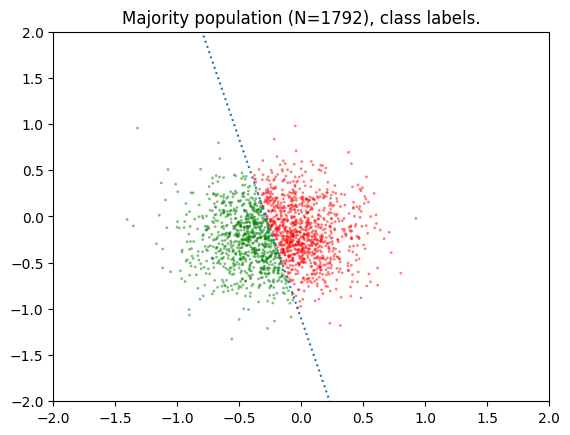

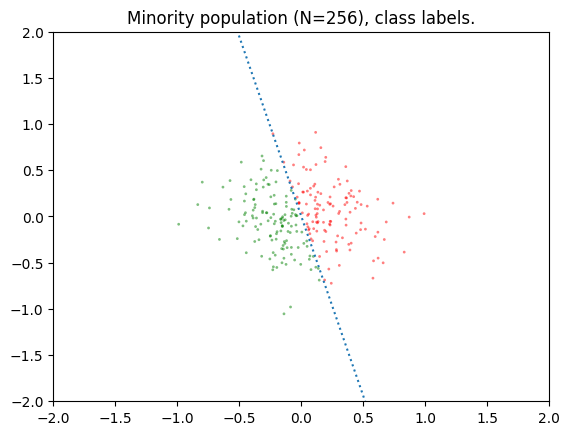

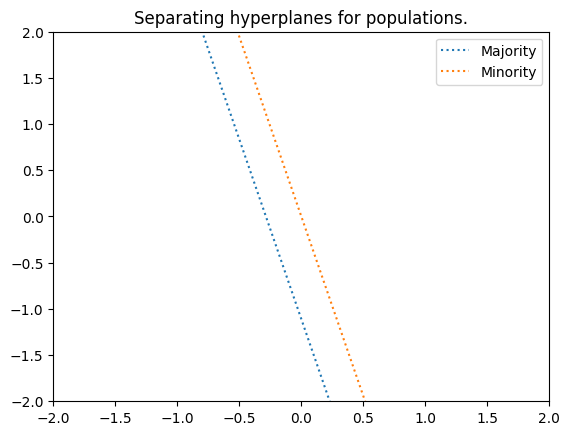

In [8]:
project_name = 'debug-dro-sweeps-classification'

max_log_samples = 1000

cvar_alpha = 0.5
batch_size = 64

parent_config = {
    'seed': 42069,
    'populations': [
        {
            'label': 'Majority',
            'size': 2048 - 256,
            'input_mean': (-0.2, -0.2),
            'input_covariance': ((0.1, 0.0), (0.0, 0.1)),
            'weights': jnp.array((3.5, 0.9, 1.0)),
            'noise_variance': 0.,
        },
        {
            'label': 'Minority',
            'size': 256,
            'input_mean': (-0., -0.),
            'input_covariance': ((0.1, 0.0), (0.0, 0.1)),
            'weights': jnp.array((3.5, 0.9, 0.0)),
            'noise_variance': 0.,
        },
    ],
    'steps': int(1e2),
    'step_size': 0.1,
    'init_weights': jnp.array((0.1, 0.1, 0.1)).reshape((3, 1)),
}

key = random.PRNGKey(parent_config['seed'])

key, subkey = random.split(key)
inputs_1, labels_1 = cdg.generate_samples(subkey, **parent_config['populations'][0])

key, subkey = random.split(key)
inputs_2, labels_2 = cdg.generate_samples(subkey, **parent_config['populations'][1])


def plot_boundary_line(plot_config, plot_extent):
    domain = jnp.linspace(-plot_extent, plot_extent, 100)

    plt.plot(domain, boundary_line(domain, plot_config['weights']), linestyle=':', label=plot_config['label'])

def plot_population(inputs, labels, plot_config, plot_extent):
    plt.scatter(
        inputs[:, 0],
        inputs[:, 1],
        alpha=0.5,
        linewidths=0,
        s=4,
        c=['red' if y else 'green' for y in labels],
    )
    plot_boundary_line(plot_config, plot_extent)

    plt.title(f'{plot_config["label"]} population (N={plot_config["size"]}), class labels.')
    plt.xlim((-plot_extent, plot_extent))
    plt.ylim((-plot_extent, plot_extent))


def plot_population_comparison(population_configs, plot_extent):

    for population_config in population_configs:
        plot_boundary_line(population_config, plot_extent)

    plt.title('Separating hyperplanes for populations.')
    plt.xlim((-plot_extent, plot_extent))
    plt.ylim((-plot_extent, plot_extent))
    plt.legend()

plot_population(inputs_1, labels_1, parent_config['populations'][0], 2)
plt.show()

plot_population(inputs_2, labels_2, parent_config['populations'][1], 2)
plt.show()

plot_population_comparison(parent_config['populations'], 2)
plt.show()

In [4]:
inputs = jnp.concatenate((inputs_1, inputs_2))
labels = jnp.concatenate((labels_1, labels_2))

log_period = max(1, parent_config['steps'] // max_log_samples)

config = parent_config | {
    'cvar_alpha': cvar_alpha,
    'batch_size': batch_size,
}

wandb.init(
    project=project_name,
    config=config,
    name=f'b={batch_size},⍺={cvar_alpha:0.2f}'
)

key, subkey = random.split(key)
training_results = dro.train_averaged_dro(
    subkey,
    inputs,
    labels,
    config['init_weights'],
    cdg.logistic_outputs,
    dro.cross_entropy_loss,
    config['step_size'],
    int(batch_size),
    float(cvar_alpha),
    config['steps'],
    log_period,
    wandb,
)

wandb.finish()

env: WANDB_SILENT=true


  0%|          | 0/15 [00:00<?, ?it/s]

In [5]:
# TODO put this in a separate analysis notebook querying wandb or something
'''
def plot_model_sweep(sweep_parameters, learned_weights, sweep_parameter_name, plot_extent):
    # TODO: pass in label, color mapping as lambda
    domain = jnp.linspace(-plot_extent, plot_extent, 100)

    for sweep_parameter, weights in zip(sweep_parameters, learned_weights):
        plt.plot(
            domain,
            boundary_line(domain, weights),
            alpha=0.7,
            label=f'${sweep_parameter_name}={sweep_parameter:0.4f}$',
            color=plt.cm.viridis((4 + jnp.log(sweep_parameter) / jnp.log(10)) / 4),
            linewidth=1,
        )

for batch_size in results.keys():
    plot_extent = 2

    plot_population_comparison([config_1, config_2], plot_extent)

    plot_model_sweep(
        cvar_alphas,
        results[batch_size]['averaged_weights'],
        '\\alpha',
        plot_extent,
    )
    plt.title(f'Learned model, batch size $n={batch_size}$')
    plt.legend()
    plt.show()
'''

"\ndef plot_model_sweep(sweep_parameters, learned_weights, sweep_parameter_name, plot_extent):\n    # TODO: pass in label, color mapping as lambda\n    domain = jnp.linspace(-plot_extent, plot_extent, 100)\n\n    for sweep_parameter, weights in zip(sweep_parameters, learned_weights):\n        plt.plot(\n            domain,\n            boundary_line(domain, weights),\n            alpha=0.7,\n            label=f'${sweep_parameter_name}={sweep_parameter:0.4f}$',\n            color=plt.cm.viridis((4 + jnp.log(sweep_parameter) / jnp.log(10)) / 4),\n            linewidth=1,\n        )\n\nfor batch_size in results.keys():\n    plot_extent = 2\n\n    plot_population_comparison([config_1, config_2], plot_extent)\n\n    plot_model_sweep(\n        cvar_alphas,\n        results[batch_size]['averaged_weights'],\n        '\\alpha',\n        plot_extent,\n    )\n    plt.title(f'Learned model, batch size $n={batch_size}$')\n    plt.legend()\n    plt.show()\n"